In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import math
from itertools import product
from util import *
from scipy.linalg import expm
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

import matplotlib
matplotlib.rc('figure', figsize=(10,10))
matplotlib.rc('figure',titlesize = 15)
matplotlib.rc('axes',labelsize = 18)
matplotlib.rc('xtick',labelsize=15)
matplotlib.rc('ytick',labelsize=15)
matplotlib.rc('font',size = 24)
matplotlib.rc('legend',fontsize = 17)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
def create_graph(N, q, p_pos_in, p_pos_out, p_neg_in, p_neg_out):

    prop_plus = np.full((q, q), p_pos_out)
    np.fill_diagonal(prop_plus, p_pos_in)
    prop_minus = np.full((q, q), p_neg_out)
    np.fill_diagonal(prop_minus, p_neg_in)
    theta = np.ones(N)
    group_probs = 1/q*np.ones(q)

    G = generate_signed_dcsbm(N, group_probs, theta, prop_plus, prop_minus)
    G.remove_nodes_from(list(nx.isolates(G)))
    mapping = {old: new for new, old in enumerate(G.nodes())}
    G = nx.relabel_nodes(G, mapping, copy=True)
    
    return G

# Fig 6

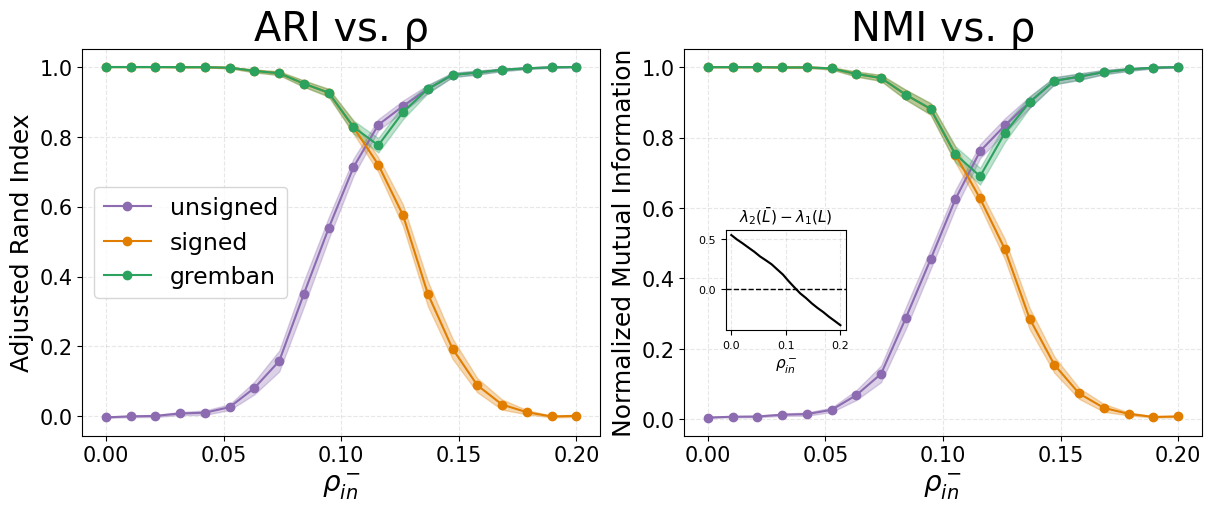

In [4]:
# Interpolate between communities and factions, varying p_neg_in = rho from 0 to 0.2
# Compute spectral clustering with unsigned, signed, and Gremban Laplacians
# Evaluate with ARI and NMI, plot with 95% CI shading

# Parameters
N = 100
q = 2
p_pos_in = 0.2
p_pos_out = 0.02
rhos = np.linspace(0, 0.2, 20)
methods = ["unsigned", "signed", "gremban"]
n_trials = 100

# Storage for metrics: shape (n_methods, n_rhos, n_trials)
ari = {m: np.zeros((len(rhos), n_trials)) for m in methods}
nmi = {m: np.zeros((len(rhos), n_trials)) for m in methods}
gap = np.zeros((len(rhos), n_trials))  # spectral gap λ2(𝐿̅) - λ1(L)

# Run multiple trials
for t in range(n_trials):
    for i, rho in enumerate(rhos):
        p_neg_in = rho
        p_neg_out = 0.22 - rho
        G = create_graph(N, q, p_pos_in, p_pos_out, p_neg_in, p_neg_out)
        true_labels = [G.nodes[n]["group"] for n in range(len(G))]
        for kind in methods:
            L = compute_laplacian(G, kind=kind)
            # get sorted eigenvalues and eigenvectors of L
            eigvals, eigvecs = np.linalg.eigh(L)
            idx = np.argsort(eigvals)
            eigvals = eigvals[idx]
            eigvecs = eigvecs[:, idx]

            # get Fiedler vector and corresponding eigenvalue
            if kind == "signed":
                fiedler = eigvecs[:, 0]
                signed_eigval = eigvals[0]
            elif kind=='unsigned':
                fiedler = eigvecs[:, 1]
                unsigned_eigval = eigvals[1]
            elif kind == "gremban":
                fiedler = eigvecs[:, 1]
                fiedler = fiedler[:G.order()]
            pred = (fiedler >= 0).astype(int)
            ari[kind][i, t] = adjusted_rand_score(true_labels, pred)
            nmi[kind][i, t] = normalized_mutual_info_score(true_labels, pred)
        gap[i,t] = unsigned_eigval-signed_eigval
        
# Prepare colors (violet, orange, teal)
colors = {
    "unsigned": "#8c6bb1",
    "signed":   "#e17e00",
    "gremban":  "#2ca25f",
}

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
# ARI subplot
ax = axes[0]
for kind in methods:
    means = ari[kind].mean(axis=1)
    sem   = ari[kind].std(axis=1, ddof=1) / np.sqrt(n_trials)
    ci_low  = means - 1.96 * sem
    ci_high = means + 1.96 * sem
    ax.plot(rhos, means, label=kind, color=colors[kind], marker='o')
    ax.fill_between(rhos, ci_low, ci_high, color=colors[kind], alpha=0.3)
ax.set_title("ARI vs. ρ")
ax.set_xlabel(r"$\rho_{in}^-$", fontsize = 20)
ax.set_ylabel("Adjusted Rand Index")
ax.grid(alpha=0.3, linestyle='--')
ax.legend()

# NMI subplot
ax = axes[1]
for kind in methods:
    means = nmi[kind].mean(axis=1)
    sem   = nmi[kind].std(axis=1, ddof=1) / np.sqrt(n_trials)
    ci_low  = means - 1.96 * sem
    ci_high = means + 1.96 * sem
    ax.plot(rhos, means, label=kind, color=colors[kind], marker='o')
    ax.fill_between(rhos, ci_low, ci_high, color=colors[kind], alpha=0.3)
ax.set_title("NMI vs. ρ")
ax.set_xlabel(r"$\rho_{in}^-$", fontsize = 20)
ax.set_ylabel("Normalized Mutual Information")
ax.grid(alpha=0.3, linestyle='--')

# spectral gap inset
gap_mean = gap.mean(axis=1)
gap_std  = gap.std(axis=1, ddof=1)
gap_low  = gap_mean - 1.96 * gap_std / np.sqrt(n_trials)
gap_high = gap_mean + 1.96 * gap_std / np.sqrt(n_trials)

# Add inset to the NMI subplot manually
inset_box = fig.add_axes([0.6, 0.35, 0.1, 0.2])  # [left, bottom, width, height] in figure coordinates
inset_box.plot(rhos, gap_mean, color='black')
inset_box.axhline(0, color='black', linestyle='--', linewidth=1)
inset_box.fill_between(rhos, gap_low, gap_high, color='gray', alpha=0.3)
inset_box.set_title(r"$\lambda_2(\bar{L}) - \lambda_1(L)$", fontsize=11)
inset_box.set_xlabel(r"$\rho_{in}^-$", fontsize=11)
inset_box.tick_params(labelsize=8)
inset_box.grid(alpha=0.3, linestyle='--')



# Fig 7

In [5]:
def create_graph_Fig7():

    G = nx.Graph()
    G.add_nodes_from(range(1, 13))

    # First clique
    A1 = [1, 2, 3]
    B1 = [4, 5, 6]
    pos1 = [(u, v) for u in A1 for v in A1 if u < v] + \
           [(u, v) for u in B1 for v in B1 if u < v]
    neg1 = [(u, v) for u in A1 for v in B1]

    # Second clique
    A2 = [10, 11, 12]
    B2 = [7, 8, 9]
    pos2 = [(u, v) for u in A2 for v in A2 if u < v] + \
           [(u, v) for u in B2 for v in B2 if u < v]
    neg2 = [(u, v) for u in A2 for v in B2]

    # Add signed edges
    for u, v in pos1 + pos2:
        G.add_edge(u, v, weight=1)
    for u, v in neg1 + neg2:
        G.add_edge(u, v, weight=-1)

    # Cross-connections between cliques 
    G.add_edge(4, 9, weight=-1)
    G.add_edge(5, 8, weight=-1)
    G.add_edge(6, 7, weight=1)
    G.add_edge(1, 7, weight=1)
    G[8][11]['weight'] = 1

    #  Layout
    pos = {}
    radius = 1.0
    # First clique centered at (0, 0)
    for i, node in enumerate([1, 2, 3, 4, 5, 6]):
        angle = math.radians(240 - i * 60)
        x = radius * math.cos(angle)
        y = radius * math.sin(angle)
        pos[node] = (x, y)
    # Second clique centered at (3, 0)
    for i, node in enumerate([7, 8, 9, 10, 11, 12]):
        angle = math.radians(240 - i * 60)
        x = 3 + radius * math.cos(angle)
        y = radius * math.sin(angle)
        pos[node] = (x, y)

    return G, pos

In [6]:

def generate_plots_gremban_embedding(G, pos):
    """
    Plot the first k nontrivial eigenvectors of the Gremban Laplacian (bar plots),
    and a 2D embedding plot using the first two nontrivial eigenvectors.
    """

    n = len(G)

    # plot the network
    fig1, ax1 = plt.subplots(figsize = (9,4))
    draw_network(G, ax=ax1, pos = pos, with_labels = True, node_size=1400, label_fontsize=25)
    fig1.tight_layout()

    # plot the Gremban expansion
    fig2, ax2 = plt.subplots(figsize = (9,6))
    G_exp = gremban_expansion(G)
    pos_exp = pos_gremban_expansion(pos, offset = 2.5)
    draw_network(G_exp, ax=ax2, pos = pos_exp, with_labels = True, node_size=2200, label_fontsize=25)
    fig2.tight_layout()

    # Compute Gremban Laplacian and sorted eigenpairs
    L_gremban = compute_laplacian(G, kind="gremban", normalized = False)
    eigvals, eigvecs = np.linalg.eigh(L_gremban)
    idx = np.argsort(eigvals)
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Extract the first k nontrivial eigenvectors
    # start at index 1 if the first eigenvector is (approximately) constant
    first_is_constant = np.allclose(eigvecs[:, 0], eigvecs[0, 0], atol=1e-8)
    start_idx = 1 if first_is_constant else 0
    embedding = eigvecs[:, start_idx:start_idx + 2]

    # plot eigenvectors
    fig3, axes3 = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
    for j in range(2):
        vec = embedding[:, j]
        ax = axes3[j]
        ax.bar(range(2 * n), vec, color='royalblue', edgecolor='black')
        ax.set_xticks([])
        ax.set_ylim([-0.45,0.45])
        ax.set_yticks([])
        ax.axhline(0, color='k', linewidth=1)
        ax.axvline(n-0.5, color='k', ls = '--', linewidth=1)
        j_global = start_idx + j
        ax.set_title(f"$\\psi_{{{j_global + 1}}}$ ($\\lambda_{{{j_global + 1}}}={eigvals[j_global]:.2f}$)")
        ax.set_xlabel("Node", fontsize = 30)


    # 2D spectral embedding
    Y = embedding[:, :2]  # take first two nontrivial eigenvectors
    fig4, ax4 = plt.subplots(figsize=(6, 6))
    for idx in range(2 * n):
        ax4.scatter(Y[idx, 0], Y[idx, 1], s=700, color='lightgrey', edgecolor='k', zorder=2)
        ax4.set_xticks([])
        ax4.set_yticks([])
        # ax4.text(Y[idx, 0], Y[idx, 1], label, fontsize=15,ha='center', va='center', zorder=3, color='black', weight='bold')
    ax4.axhline(0, color='k', linestyle='--', alpha=0.3)
    ax4.axvline(0, color='k', linestyle='--', alpha=0.3)
    ax4.set_xlabel(f"$\psi_{start_idx+1}$", fontsize = 30)
    ax4.set_ylabel(f"$\psi_{start_idx+2}$", fontsize = 30)



<>:60: SyntaxWarning: invalid escape sequence '\p'
<>:61: SyntaxWarning: invalid escape sequence '\p'
<>:60: SyntaxWarning: invalid escape sequence '\p'
<>:61: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_30439/66277514.py:60: SyntaxWarning: invalid escape sequence '\p'
  ax4.set_xlabel(f"$\psi_{start_idx+1}$", fontsize = 30)
/tmp/ipykernel_30439/66277514.py:61: SyntaxWarning: invalid escape sequence '\p'
  ax4.set_ylabel(f"$\psi_{start_idx+2}$", fontsize = 30)


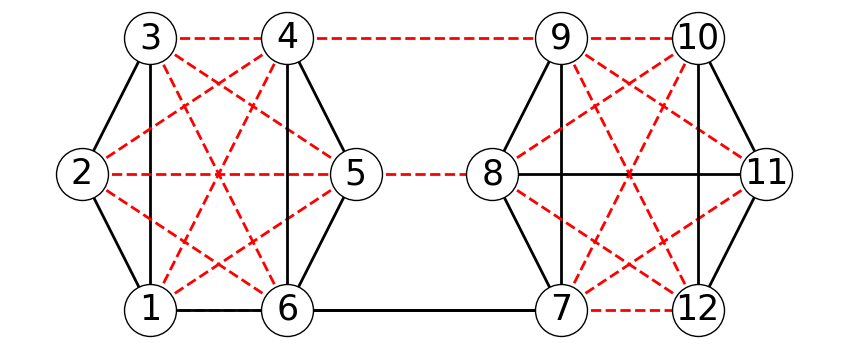

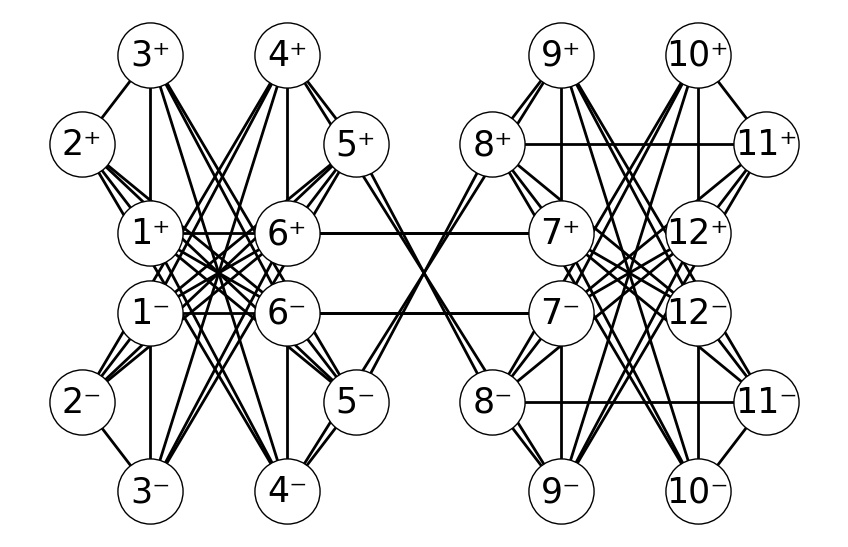

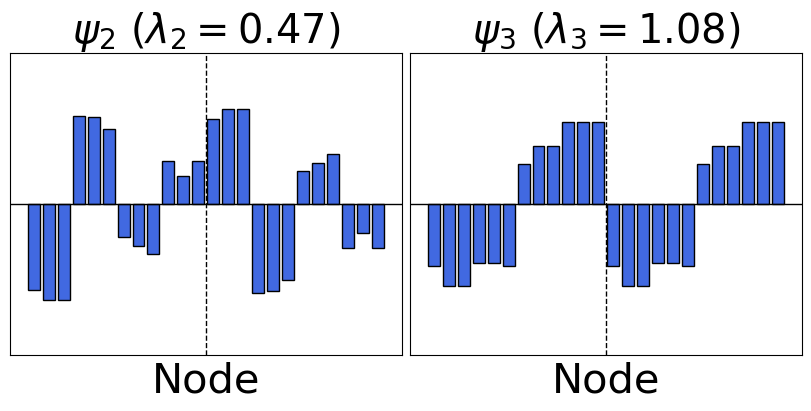

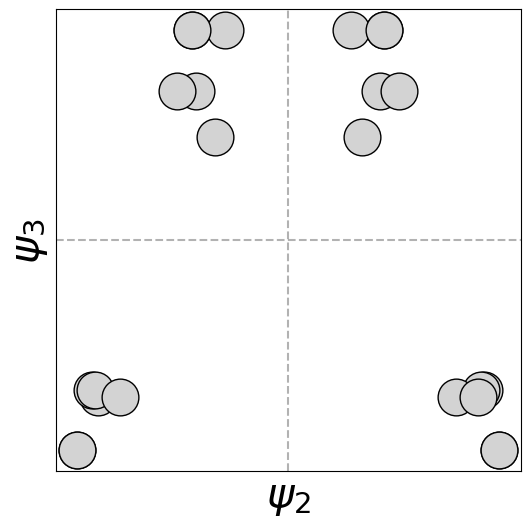

In [7]:
G, pos = create_graph_Fig7()
generate_plots_gremban_embedding(G, pos = pos)

# Fig 8

In [8]:
def faction_graph():
    # Generate two cycle graphs with 10 nodes each
    G1 = nx.cycle_graph(10)
    G2 = nx.cycle_graph(10)
    G2 = nx.relabel_nodes(G2, lambda x: x + 10)    # Relabel nodes in G2

    # Add three positive chords to each cycle to reduce average path length
    rng = np.random.default_rng(seed=42)
    chords_1 = rng.choice(list(nx.non_edges(G1)), size=7, replace=False)
    chords_2 = rng.choice(list(nx.non_edges(G2)), size=7, replace=False)
    G1.add_edges_from(chords_1)
    G2.add_edges_from(chords_2)

    # Combine the two graphs
    G = nx.Graph()
    G.add_edges_from(G1.edges())
    G.add_edges_from(G2.edges())

    # Add 8 inter-group edges with negative weights
    cross_edges = rng.choice(list(product(range(10), range(10, 20))),
        size=8,  replace=False)
    G.add_edges_from(cross_edges)

    for node in G.nodes():
        G.nodes[node]["group"] = 0 if node < 10 else 1

    # Assign weights: +1 for intra-community edges, -1 for inter-community edges (with 80% prob)
    for u, v in G.edges():
        if (u < 10 and v < 10) or (u >= 10 and v >= 10):
            G[u][v]['weight'] = 1
        else:
            if np.random.rand()< 0.8:
                G[u][v]['weight'] = -1
            else:
                G[u][v]['weight'] = 1

    return G




def community_graph():
    # Generate two cycle graphs with 10 nodes each
    G1 = nx.cycle_graph(10)
    G2 = nx.cycle_graph(10)
    G2 = nx.relabel_nodes(G2, lambda x: x + 10)

    # Add three positive chords to each cycle to reduce average path length
    rng = np.random.default_rng(seed=42)
    chords_1 = rng.choice(list(nx.non_edges(G1)), size=7, replace=False)
    chords_2 = rng.choice(list(nx.non_edges(G2)), size=7, replace=False)

    G1.add_edges_from(chords_1)
    G2.add_edges_from(chords_2)

    # Combine the two graphs
    G = nx.Graph()
    G.add_edges_from(G1.edges())
    G.add_edges_from(G2.edges())

    for node in G.nodes():
        G.nodes[node]["group"] = 0 if node < 10 else 1
    
    # Add 2 inter-group edges 
    cross_edges = rng.choice(list(product(range(10), range(10, 20))),
        size=2, replace=False)
    G.add_edges_from(cross_edges)

    # Assign weights randomly (with more abundance of positive edges)
    for u, v in G.edges():
        if np.random.rand()< 0.6:
            G[u][v]['weight'] = -1
        else:
            G[u][v]['weight'] = 1

    return G




def circular_two_group_layout(G, group_attr="group", radius=3.0, separation=7.0):
    pos = {}
    group0 = np.sort([n for n in G.nodes if G.nodes[n][group_attr] == 0])
    group1 = np.sort([n for n in G.nodes if G.nodes[n][group_attr] == 1])
    angle_step_0 = 2 * np.pi / len(group0)
    angle_step_1 = 2 * np.pi / len(group1)

    for i, node in enumerate(group0):
        angle = i * angle_step_0
        pos[node] = (radius * np.cos(angle) - separation / 2, radius * np.sin(angle))
    for i, node in enumerate(group1):
        angle = i * angle_step_1
        pos[node] = (radius * np.cos(angle) + separation / 2, radius * np.sin(angle))
    return pos



def plot_dynamics_Gremban(G):
    """
    Simulate and plot diffusion dynamics using unsigned, signed, and Gremban Laplacians.
    """

    # Plot the network with groups
    pos = circular_two_group_layout(G)
    group_assignments = nx.get_node_attributes(G, "group")
    group_colors = {
        0: "#6baed6",  # soft blue
        1: "#fd8d3c",  # warm orange
    }
    fig1, ax1 = plt.subplots(figsize = (8,4))
    draw_network(
        G,
        ax = ax1,
        pos=pos,
        differenciate_groups=True,
        group_assignments=group_assignments,
        group_colors=group_colors,
        with_labels=True,
    )       

    # Compute Laplacians
    A = nx.to_numpy_array(G)
    N = len(A)
    group_attrs = nx.get_node_attributes(G, "group")
    L_unsigned = compute_laplacian(A, kind="unsigned", normalized=False)
    L_signed = compute_laplacian(A, kind="signed", normalized=False)
    L_gremban = compute_laplacian(A, kind="gremban", normalized=False)

    # Initial condition
    np.random.seed(0)
    x0_unsigned = np.zeros(N); x0_unsigned[0] = 1
    x0_signed = np.zeros(N); x0_signed[0] = 1
    x0_gremban = np.zeros(2*N); x0_gremban[0] = 1

    # Solve diffusion equation: x(t) = exp(-L t) x0
    t_vals = np.linspace(0, 20, 50)
    x_t_unsigned = np.array([expm(-L_unsigned * t) @ x0_unsigned for t in t_vals])
    x_t_signed = np.array([expm(-L_signed * t) @ x0_signed for t in t_vals])
    x_t_gremban = np.array([expm(-L_gremban * t) @ x0_gremban for t in t_vals])

    # DYNAMICS PLOTS
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True)
    colors = [group_colors[group_attrs[i]] for i in range(N)]

    # Unsigned Laplacian plot
    for i in range(N):
        axs[0].plot(t_vals, x_t_unsigned[:, i], color=colors[i], alpha=0.7)
    axs[0].set_title(r"$\bar{L}$ (unsigned)")
    axs[0].set_ylim([-0.15,0.15])
    axs[0].set_ylabel(r"$x_i(t)$", fontsize = 16)

    # Signed Laplacian plot
    for i in range(N):
        axs[1].plot(t_vals, x_t_signed[:, i], color=colors[i], alpha=0.7)
    axs[1].set_title("$L$ (signed)")
    axs[1].set_ylim([-0.15,0.15])

    # Gremban-expanded Laplacian plot
    for i in range(N):
        color = colors[i]
        axs[2].plot(t_vals, x_t_gremban[:, i], color=color, linestyle='-', alpha=0.7)
        axs[2].plot(t_vals, x_t_gremban[:, i + N], color=color, linestyle='--', alpha=0.7)
    axs[2].set_title(r"$\mathcal{L}$ (Gremban)")
    axs[2].set_ylim([-0.15,0.15])
    axs[2].set_xlabel("Time")
    fig.tight_layout()

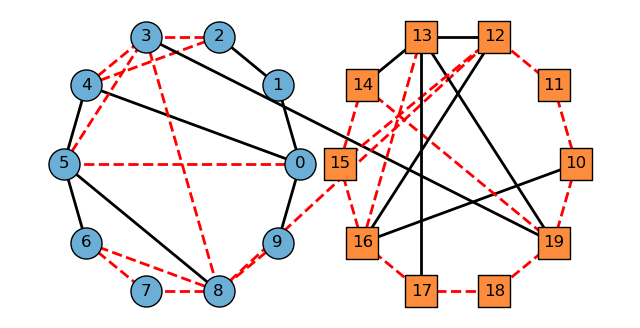

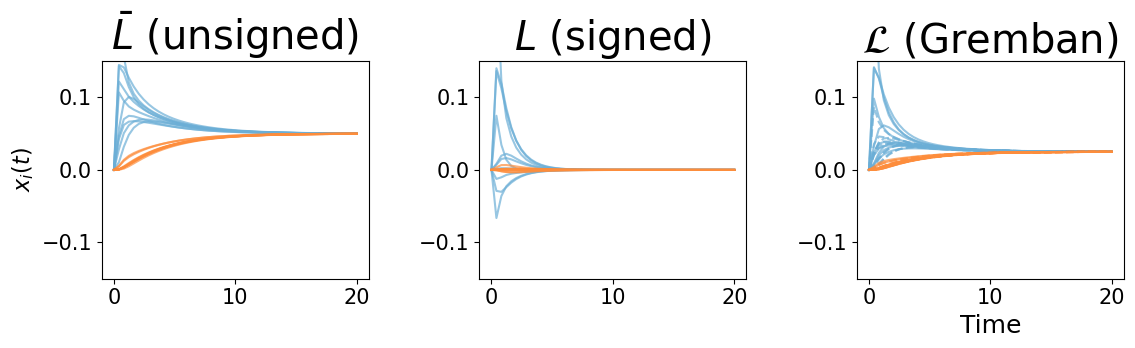

In [9]:
G = community_graph()
plot_dynamics_Gremban(G)

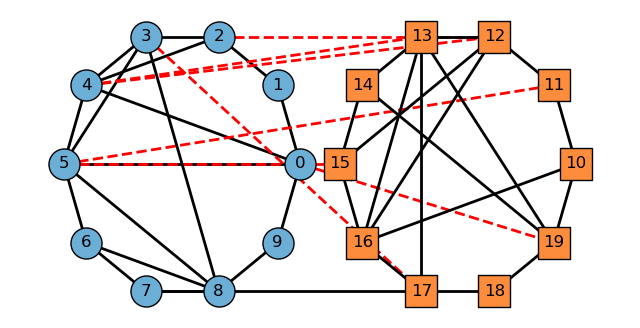

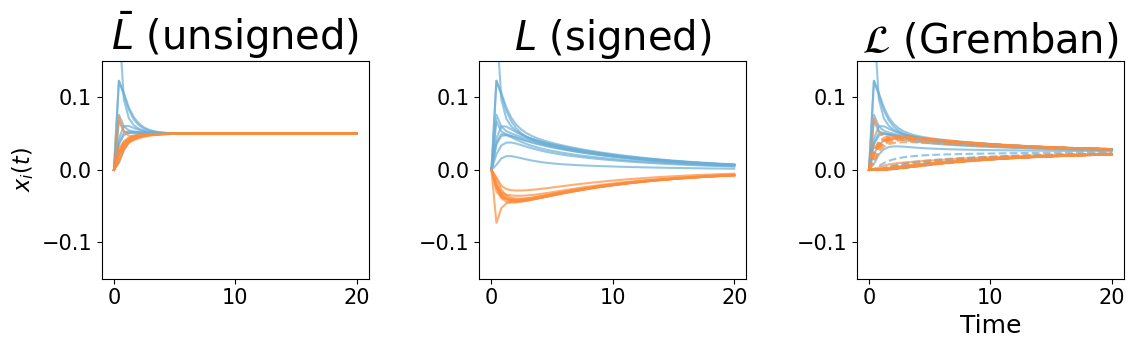

In [10]:
G = faction_graph()
plot_dynamics_Gremban(G)

# Figs 10, 11

In [11]:
def plot_laplacian_spectra(G):
    """
    Compute and plot spectrum and Fiedler vector for: standard Laplacian, signed Laplacian, and Gremban-expanded Laplacian.
    """
    # Prepare laplacians
    laplacians = [
        ("Unsigned L", compute_laplacian(G, kind="unsigned")),
        ("Signed L",   compute_laplacian(G, kind="signed")),
        ("Gremban L",  compute_laplacian(G, kind="gremban")),
    ]
    # Get group labels
    group_labels = nx.get_node_attributes(G, "group")
    fig, axes = plt.subplots(2, 3, figsize=(12, 8), constrained_layout=True)
    
    for i, (title, L) in enumerate(laplacians):

        # get sorted eigenvalues and eigenvectors of L
        eigvals, eigvecs = np.linalg.eigh(L)
        idx = np.argsort(eigvals)
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:, idx]

        # plot spectrum
        ax_spec = axes[0, i]
        ax_spec.plot(eigvals, marker='o', linestyle='-', linewidth=1.2)
        ax_spec.set_title(f"{title}")
        ax_spec.set_xlabel("Rank")
        if i == 0: ax_spec.set_ylabel("$\\lambda$", fontsize = 22)
        ax_spec.grid(alpha=0.3, linestyle='--')
        ax_spec.set_ylim([-0.5,max(eigvals)+0.5])
        
        # plot Fiedler vector
        ax_bar = axes[1, i]
        if title == "Signed L":
            fiedler = eigvecs[:, 0]  # the non-constant eigenv in the signed Laplacian is the first one
        else:
            fiedler = eigvecs[:, 1]
        if title != "Gremban L":
            colors = [f"C{group_labels.get(j, 0)}" for j in range(len(fiedler))]
        else:
            # expanded graph: length 2N, labels like "i⁺","i⁻"
            colors = []
            for idx in range(2 * len(G)):
                orig = idx % len(G)
                colors.append(f"C{group_labels.get(orig, 0)}")
        ax_bar.bar(range(len(fiedler)), fiedler, color=colors)  # build colors by original index
        ax_bar.set_xlabel("Component index")
        ax_bar.axhline(0, color='k', linewidth=1)
    
    plt.show()

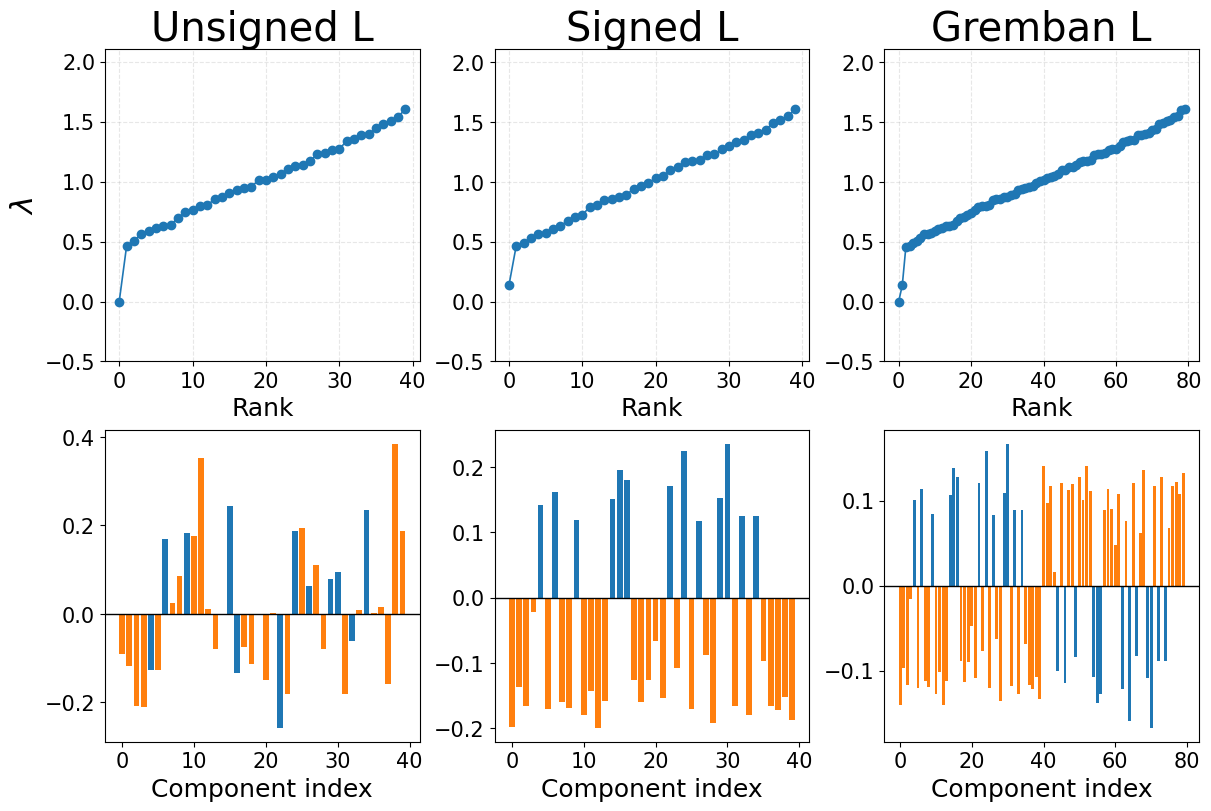

In [12]:
# Spectrum and Fiedler vector for faction structure
N = 40
q = 2
p_pos_in = 0.2
p_pos_out = 0.02
p_neg_in = 0.02
p_neg_out = 0.2

G = create_graph(N, q, p_pos_in, p_pos_out, p_neg_in, p_neg_out)
plot_laplacian_spectra(G)

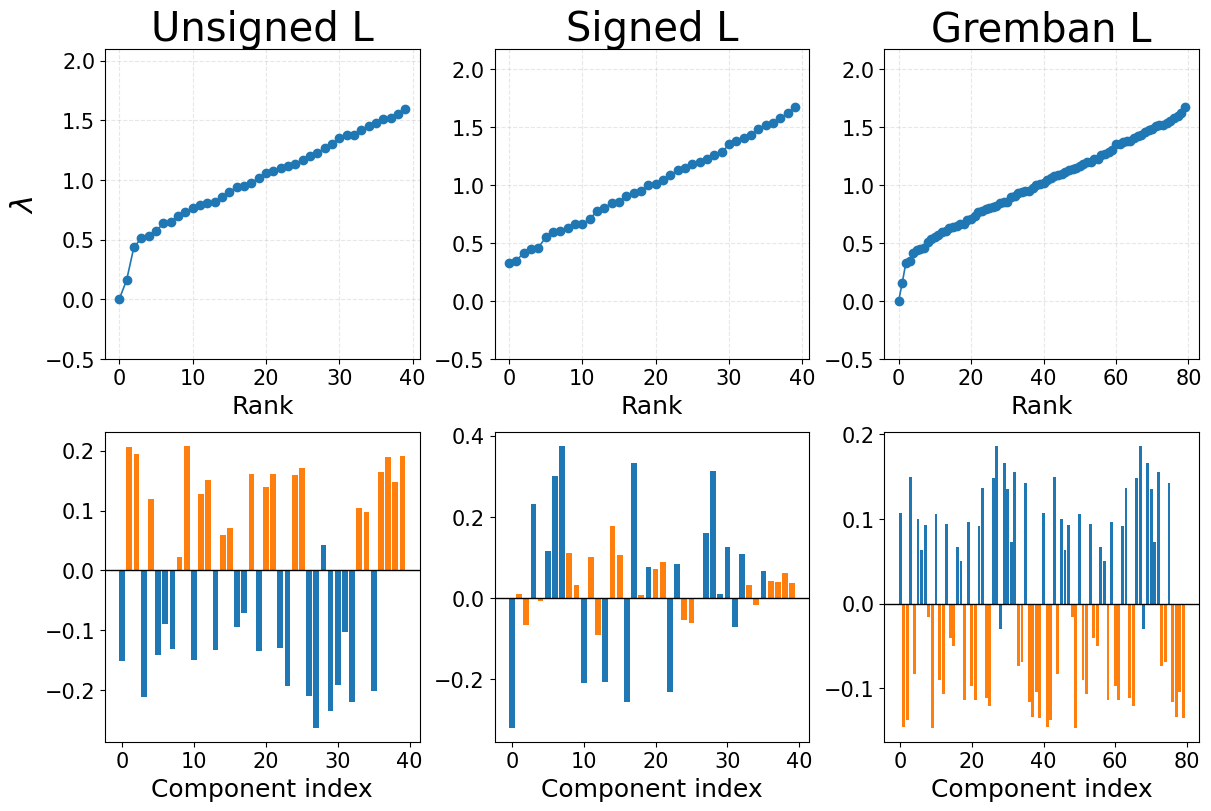

In [13]:
# Spectrum and Fiedler vector for community structure
N = 40
q = 2
p_pos_in = 0.2
p_pos_out = 0.02
p_neg_in = 0.2
p_neg_out = 0.02

G = create_graph(N, q, p_pos_in, p_pos_out, p_neg_in, p_neg_out)
plot_laplacian_spectra(G)